In [73]:
from solver import Solver
from model import Net, NetConnected, NetConnected100
from model_nomatrix import NetNomatrix
from model_nomatrix3 import NetNomatrix16, NetNomatrix16V2
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
import torch
from experiment import get_data_loader
from lossfn import *
import pandas as pd

In [173]:
def plot_train_loss(dim, paths, logscale=True, labels=None, includeTest=False, model_class=Net, legendTitle=None, filename=None, only_test=False, ylabel="Loss value", small=False, legend=True, miny=None):
    fig = plt.figure(figsize=((6,4) if small else (10,6)))
    handles = []
    legend_labels = []
    labels_replacement = labels if labels is not None else ([''] * len(paths))
    print(labels_replacement)
    for path, label in zip(paths, labels_replacement):
        if not only_test:
            if labels is not None:
                handles.append(plt.plot([],marker="", ls="", color="black")[0])
                legend_labels.append(label)
        # Plot train loss
        model = model_class(dim)
        solver = Solver(model)
        solver.load_checkpoint(path)
        if not only_test:
            for key in solver.hist["individual_train_losses"]:
                p = plt.plot(solver.hist["iterations"][1:], solver.hist["individual_train_losses"][key][1:])[0]
                handles.append(p)
                legend_labels.append("MSE" if key == "mse" else 
                                     ("Norm loss" if key == "norm" else 
                                      ("Squared det loss" if key == "det_sq" else
                                       ("Linear det loss" if key == "det_lin" else
                                      key.capitalize()))))
                if key == "det_lin":
                    p = plt.plot(solver.hist["iterations"][1:], [-x for x in solver.hist["individual_train_losses"][key][1:]])[0]
                    handles.append(p)
                    legend_labels.append("Negative linear det loss")
        if includeTest or only_test:
            p = plt.plot(solver.hist["iterations"][1:], solver.hist["test_loss"][1:])[0]
            handles.append(p)
            legend_labels.append('Test MSE' if not only_test else label)
    if legend:
        if legendTitle is not None:
            plt.legend(handles, legend_labels, loc='best', title=legendTitle, ncol=(1 if only_test else len(paths)))
        else:
            plt.legend(handles, legend_labels, loc='best', ncol=(1 if only_test else len(paths)))
    if logscale:
        plt.yscale('log')
    plt.ylabel(ylabel)
    plt.xlabel("Iteration")
    if miny is not None:
        plt.ylim(bottom=miny)
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".png", format="png", bbox_inches='tight')
        plt.close()

In [3]:
def plot_test_loss(dim, train_range, keys, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, legendTitle=None, filename=None):
    fig = plt.figure(figsize=(13,7))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            model = Net(dim, n_hidden_layers=max(1, int(math.log(dim, 2))))
            solver = Solver(model)
            filepath = get_path(key, n_train)
            if os.path.exists(filepath):
                ntrains.append(n_train)
                solver.load_checkpoint(filepath)
                test_loss.append(solver.hist["test_loss"][-1])
                if includeNormed:
                    solver.fn_pred = fn_pred_normed
                    test_loss_normed.append(solver.test(test_loader, prints=False))
        plt.plot(ntrains, test_loss, label=key)
        if includeNormed:
            plt.plot(ntrains, test_loss_normed, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    if logscale:
        plt.yscale('log')
    plt.ylabel("Test MSE loss")
    plt.xlabel("Number of training data points")
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".svg", format="svg")
        plt.close()

In [31]:
def plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=False, max_iteration=float("inf"), model_class=lambda key: Net, legendTitle=None, filename=None, label=lambda key: key, small=False):
    fig = plt.figure(figsize=((6,4) if small else (10,6)))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = model_class(key)(dim)
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        if len(test_loss):
            if percentiles:
                p = plt.plot(ntrains, np.median(test_loss, axis=1), label=label(key))
                #color = p[0].get_color()
                #plt.plot(ntrains, np.percentile(test_loss, 80, axis=1), linestyle='--', color=color, linewidth=0.5)
                #plt.plot(ntrains, np.percentile(test_loss, 20, axis=1), linestyle='--', color=color, linewidth=0.5)
            else: 
                p = plt.plot(ntrains, test_loss.mean(axis=1), label=label(key), linestyle='--', marker='o')
                # plt.errorbar(ntrains, test_loss.mean(axis=1), yerr=test_loss.std(axis=1), capsize=5, markeredgewidth=2, label=label(key))
        if includeNormed:
            plt.errorbar(ntrains, test_loss_normed.mean(axis=1), yerr=test_loss_normed.std(axis=1), capsize=5, markeredgewidth=2, label=str(key)+'_testnormed')
    if legendTitle is not None:
        plt.legend(loc='best', title=legendTitle)
    else:
        plt.legend(loc='best')
    plt.xlabel("Train dataset size $N_{train}$")
    plt.ylabel("Test MSE loss")
    if logscale:
        plt.yscale('log')
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".png", format="png", bbox_inches='tight')
        plt.close()

In [98]:
def stats(dim, train_range, keys, stat_range, get_path, logscale=True, min_n_train=0, max_n_train=float('inf'), includeNormed=False, percentiles=False, max_iteration=float("inf"), model_class=lambda key: Net, legendTitle=None, filename=None, label=lambda key: key, small=False):
    # fig = plt.figure(figsize=((6,4) if small else (10,6)))
    df = pd.DataFrame(columns=['key']+list(train_range))
    if includeNormed:
        test_loader = get_data_loader(dim, 512, seed=0, shuffle=False, batch_size=512)
    for key in keys:
        test_loss = []
        test_loss_normed = []
        ntrains = []
        for n_train in train_range:
            if n_train < min_n_train or n_train > max_n_train:
                continue
            test_loss_n_train = []
            test_loss_normed_n_train = []
            ntrains.append(n_train)
            for stat_val in stat_range:
                model = model_class(key)(dim)
                solver = Solver(model)
                filepath = get_path(key, n_train, stat_val)
                if os.path.exists(filepath):
                    solver.load_checkpoint(filepath)
                    test_index = len(solver.hist["test_loss"]) - 1
                    while (solver.hist["iterations"][test_index] > max_iteration):
                        test_index -= 1
                    test_loss_n_train.append(solver.hist["test_loss"][test_index])
                    if includeNormed:
                        solver.fn_pred = fn_pred_normed
                        test_loss_normed_n_train.append(solver.test(test_loader, prints=False))
                else:
                    print('Missing filepath:')
                    print(filepath)
            test_loss.append(test_loss_n_train)
            test_loss_normed.append(test_loss_normed_n_train)
        test_loss = np.array(test_loss)
        test_loss_normed = np.array(test_loss_normed)
        # add to dataframe
        for x in zip(*test_loss):
            df.loc[df.shape[0]] = [key] + list(x)
    return df

In [5]:
def get_angles_norms_dets(test_loader, train_loader, solver):
    all_angles = []
    all_norms = []
    all_dets = []
    all_l2 = []
    for loader in [test_loader, train_loader]:
        for (points, angles, points_rotated) in loader:
            output_matrix, prediction = solver.forward(angles, points)
            all_angles += [x.item() for x in angles]
            all_norms += list(torch.norm(prediction, 2, 1).data.numpy())
            if output_matrix is not None:
                all_dets += [torch.det(mat).item() for mat in output_matrix]
            else:
                all_dets += [0 for _ in prediction]
            all_l2 += list(torch.sum(torch.nn.functional.mse_loss(prediction, points_rotated, reduction='none'), dim=1).detach().numpy())
    angles_norms = list(zip(all_angles, all_norms, all_dets, all_l2))
    angles_norms_sorted = list(zip(*sorted(angles_norms)))
    return angles_norms_sorted

In [6]:
def get_angles_stats_buckets(test_loader, train_loader, solver, n_buckets=50):
    angles_stats = get_angles_norms_dets(test_loader, train_loader, solver)
    angles_stats = [list(l) for l in zip(*angles_stats)]
    angle_min, angle_max = -math.pi, math.pi
    linspace = np.linspace(angle_min, angle_max, n_buckets+1)
    angles = [(linspace[i] + linspace[i+1])/2 for i in range(n_buckets)]
    buckets = [[] for _ in angles]
    linspace_i = 0
    for stats in angles_stats:
        angle = stats[0]
        while angle > linspace[linspace_i + 1]:
            linspace_i += 1
        buckets[linspace_i].append(stats)
    return angles, [list(zip(*b)) for b in buckets]

In [7]:
def plot_det_analysis_old(dim, n_train, train_seed, labels, paths, model_class=lambda: Net, legendTitle=None, use_absolute=True, include_mse=True, scale_by_mean=False):
    fig = plt.figure(figsize=(13,7))
    train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
    test_loader = get_data_loader(dim, 4096, seed=0, shuffle=False, batch_size=512)
    model = model_class()(dim)
    solver = Solver(model)
    for (points, angles, points_rotated) in train_loader:
        for angle in angles:
            plt.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
    linestyles = ['-', '--', ':', '-.']
    colors = []
    handles = []
    legend_labels = []
    for i, path in enumerate(paths):
        handles.append(plt.plot([],marker="", ls="", color="black")[0])
        legend_labels.append(labels[i])
        solver.load_checkpoint(path)
        angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver, n_buckets=100)
        dets = [abs(1 - np.array(b[2]).mean()) if use_absolute else np.array(b[2]).mean() for b in buckets]
        det_mean = np.mean(dets) if scale_by_mean else 1
        p = plt.plot(angles, [det / det_mean for det in dets], linestyle=linestyles[0])[0]
        handles.append(p)
        legend_labels.append('Determinant')
        colors.append(p.get_color())
        norms = [abs(1 - np.array(b[1]).mean()) if use_absolute else np.array(b[1]).mean() for b in buckets]
        norm_mean = np.mean(norms) if scale_by_mean else 1
        p = plt.plot(angles, [norm / norm_mean for norm in norms], linestyle=linestyles[1], color = p.get_color())[0]
        # p = plt.plot(angles, [abs(1 - np.array(b[1]).mean()) for b in buckets], label='Norm', linestyle=linestyles[1], color = p.get_color())[0]
        handles.append(p)
        legend_labels.append('Norm')
        #plt.plot(angles, [(np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
        #plt.plot(angles, [(np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
        if include_mse:
            p = plt.plot(angles, [np.array(b[3]).mean() for b in buckets], linestyle=linestyles[2], color = p.get_color())[0]
            handles.append(p)
            legend_labels.append('MSE')
    plt.ylabel("Norm, Determinant, MSE Loss")
    plt.xlabel("Alpha")
    if legendTitle is not None:
        plt.legend(handles, legend_labels, loc='best', title=legendTitle, ncol=len(paths))
    else:
        plt.legend(handles, legend_labels, loc='best', ncol=len(paths))
    fig.savefig("figs/pnlty_det_anglestat.eps", format="eps")
    plt.show()

In [155]:
def plot_det_analysis(dim, n_train, train_seed, labels, paths, model_class=lambda: Net, legendTitle=None, use_absolute=True, include_mse=True, scale_by_mean=False, filename=None, npoints=4096):
    # fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,7))
    # fig.subplots_adjust(wspace=0)
    fig = plt.figure(figsize=(13,7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[10,1], wspace=0)
    ax = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharey=ax)
    ax2.get_yaxis().set_visible(False)

    #fig = plt.figure(figsize=(13,7))
    train_loader = get_data_loader(dim, n_train, seed=train_seed, shuffle=False, batch_size=512)
    test_loader = get_data_loader(dim, npoints, seed=0, shuffle=False, batch_size=512)#4096
    model = model_class()(dim)
    solver = Solver(model)
    for (points, angles, points_rotated) in train_loader:
        for angle in angles:
            ax.axvline(x=angle.item(), color='black', linestyle='--', linewidth=0.2)
    linestyles = ['-', '--', ':', '-.']
    colors = []
    handles = []
    legend_labels = []
    n_cols = 0
    for i, path in enumerate(paths):
        if labels[i] == "empty":
            p = ax.plot([0])[0]
            print(p.get_color())
            continue
        n_cols += 1
        handles.append(plt.plot([],marker="", ls="", color="black")[0])
        legend_labels.append(labels[i])
        solver.load_checkpoint(path)
        angles, buckets = get_angles_stats_buckets(test_loader, train_loader, solver, n_buckets=100)
        dets = [abs(1 - np.array(b[2]).mean()) if use_absolute else np.array(b[2]).mean() for b in buckets]
        det_mean = np.mean(dets) if scale_by_mean else 1
        p = ax.plot(angles, [det / det_mean for det in dets], linestyle=linestyles[0])[0]
        ax2.axhline(np.mean(dets) / det_mean, linestyle=linestyles[0], color = p.get_color())
        handles.append(p)
        legend_labels.append('Determinant')
        colors.append(p.get_color())
        norms = [abs(1 - np.array(b[1]).mean()) if use_absolute else np.array(b[1]).mean() for b in buckets]
        norm_mean = np.mean(norms) if scale_by_mean else 1
        p = ax.plot(angles, [norm / norm_mean for norm in norms], linestyle=linestyles[1], color = p.get_color())[0]
        # p = plt.plot(angles, [abs(1 - np.array(b[1]).mean()) for b in buckets], label='Norm', linestyle=linestyles[1], color = p.get_color())[0]
        ax2.axhline(np.mean(norms) / norm_mean, linestyle=linestyles[1], color = p.get_color())
        handles.append(p)
        legend_labels.append('Norm')
        #plt.plot(angles, [(np.array(b[1]).mean()) for b in buckets], label=str(det_weight)+' '+'Norm')
        #plt.plot(angles, [(np.array(b[2]).mean()) for b in buckets], label=str(det_weight)+' '+'Det')
        if include_mse:
            mses = [np.array(b[3]).mean() for b in buckets]
            p = ax.plot(angles, mses, linestyle=linestyles[2], color = p.get_color())[0]
            print(np.mean(mses))
            ax2.axhline(np.mean(mses), linestyle=linestyles[2], color = p.get_color())
            handles.append(p)
            legend_labels.append('MSE')
    if use_absolute:
        ax.set_ylabel("Norm violation, Determinant violation, MSE Loss")
    else:
        ax.set_ylabel("Norm, Determinant, MSE Loss")
    ax.set_xlabel("Alpha")
    # plt.ylabel("Norm, Determinant, MSE Loss")
    # plt.xlabel("Alpha")
    if legendTitle is not None:
        ax.legend(handles, legend_labels, loc='best', title=legendTitle, ncol=n_cols)
    else:
        ax.legend(handles, legend_labels, loc='best', ncol=n_cols)
    # ax2.set_xticklabels(['', '                 Avg'])
    ax2.set_xticks([0])
    ax2.set_xticklabels(["Avg"])
    plt.show()
    if filename:
        fig.savefig("figs/"+filename+".png", format="png", bbox_inches='tight')
        plt.close()

# Plots

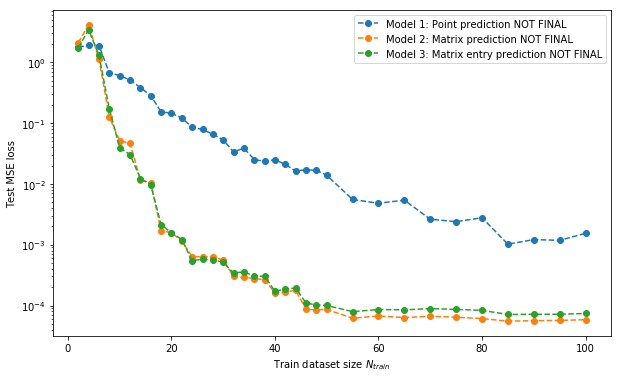

In [336]:
# Plot to compare all models
dim = 2
train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
keys = list(range(3))
n_runs = 2
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    if key == 0:
        checkpoint_dir += 'round2_normweight_model3_V2_range2/'
        checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    elif key == 1:
        checkpoint_dir += 'round2_detweight_model2_100_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    elif key == 2:
        checkpoint_dir += 'round2_detweight_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:[NetNomatrix16V2, NetConnected100, Net][key], label=lambda key:["Model 1: Point prediction NOT FINAL", "Model 2: Matrix prediction NOT FINAL", "Model 3: Matrix entry prediction NOT FINAL"][key], filename="models")


In [61]:
matrix_entry_model = True # if possible, take false, else do with old model

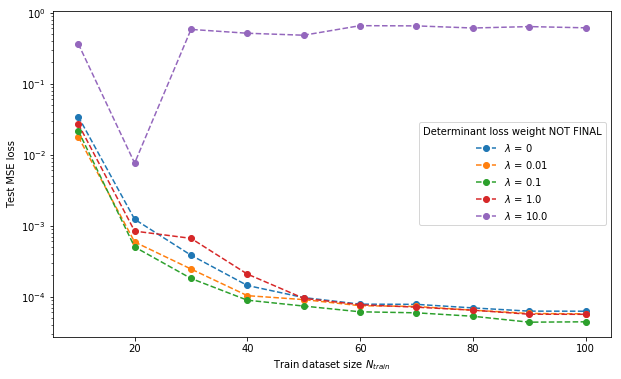

In [471]:
if matrix_entry_model:
    # Plot of det loss for wide range - matrix entry model
    dim = 2
    train_range = list(range(10, 101, 10))
    keys = [0, 1e-2, 1e-1, 1e0, 1e1]
    n_runs = 3
    stat_range = range(1683, 1683 + n_runs, 1)
    def get_path(key, n_train, train_seed):
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_detweight_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
        return checkpoint_dir + 'final.pkl'

    plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight NOT FINAL", filename="pnlty_det_large")
else:
    # Plot of det loss for wide range - matrix model
    dim = 2
    train_range = list(range(2, 50, 2)) + list(range(50, 101, 5))
    keys = [0, 1e-2, 1e-1, 1e0]
    n_runs = 1
    stat_range = range(1683, 1683 + n_runs, 1)
    def get_path(key, n_train, train_seed):
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_detweight_model2_100_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
        return checkpoint_dir + 'final.pkl'

    plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:NetConnected100, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

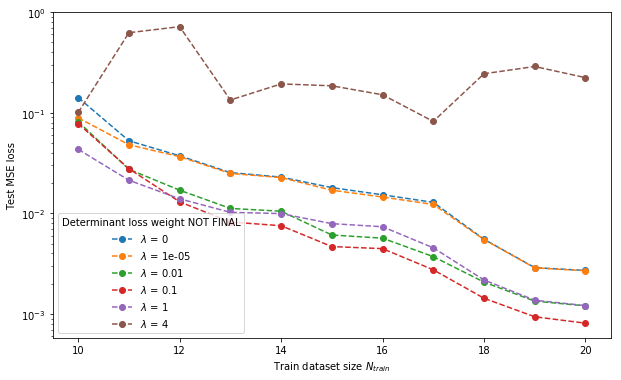

In [459]:
# TODO: Weights 1e-4 / 1e-3, 1e-2, 1e-1, 1e0, 4
if matrix_entry_model:
    # Plot for det loss for small range - matrix entry model
    dim = 2
    train_range = list(range(10, 21, 1))
    # keys = [0, 1e-2, 1e-1, 1e0]
    keys = [0, 1e-5, 1e-2, 0.1, 1, 4]
    # det_weights = [0, 1e-5, 1e-2, 0.1, 0.2, 0.5, 1, 2, 4]
    n_runs = 20
    stat_range = range(1683, 1683 + n_runs, 1)
    def get_path(key, n_train, train_seed):
        checkpoint_dir = 'checkpoints/'
        # checkpoint_dir += 'round2_detweight_range2/'
        checkpoint_dir += 'round2_detweight3/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
        return checkpoint_dir + 'final.pkl'

    plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight NOT FINAL", filename="pnlty_det")
else:
    # Plot for det loss for small range
    dim = 2
    train_range = list(range(10, 21, 1))
    keys = [0, 1e-2, 1e-1, 1e0]
    n_runs = 20
    stat_range = range(1683, 1683 + n_runs, 1)
    def get_path(key, n_train, train_seed):
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_detweight_model2_100_range2/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, train_seed)
        return checkpoint_dir + 'final.pkl'

    plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:NetConnected100, label=lambda key: "$\lambda$ = "+str(key), legendTitle="Determinant loss weight")

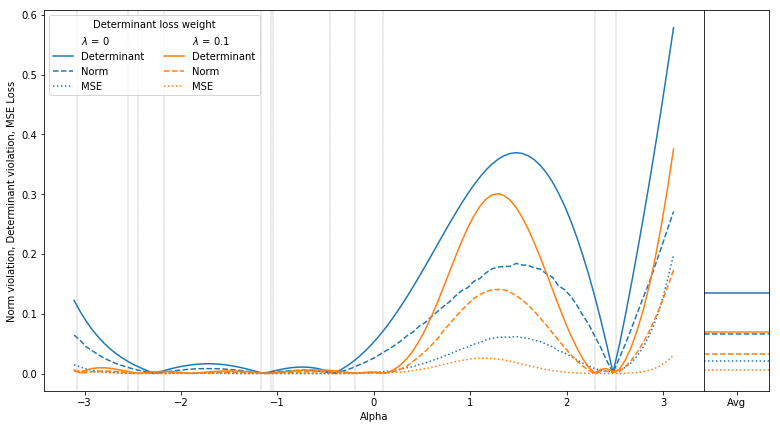

In [68]:
# MAKE SMOOTHER
if matrix_entry_model:
    # Special analysis after det weight (Note: Make smoother with more test data in plot_det_analysis)
    dim = 2
    n_train = 12
    train_seed = 1683
    paths = []
    labels = []
    for det_weight in [0, 0.1]:
        path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, det_weight, n_train, train_seed)
        paths.append(path)
        labels.append("$\lambda$ = "+str(det_weight))
    plot_det_analysis(dim, n_train, train_seed, labels, paths, legendTitle="Determinant loss weight", filename="pnlty_det_analysis", npoints=64*4096)
else:
    # Special analysis after det weight (Note: Make smoother with more test data in plot_det_analysis)
    dim = 2
    n_train = 12
    train_seed = 1683
    paths = []
    labels = []
    for det_weight in [0, 0.1]:
        path = 'checkpoints/round2_detweight_model2_100_range2/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(dim, det_weight, n_train, train_seed)
        paths.append(path)
        labels.append("$\lambda$ = "+str(det_weight))
    plot_det_analysis(dim, n_train, train_seed, labels, paths, legendTitle="Determinant loss weight", model_class=lambda: NetConnected100)
# MAKE SMOOTHER

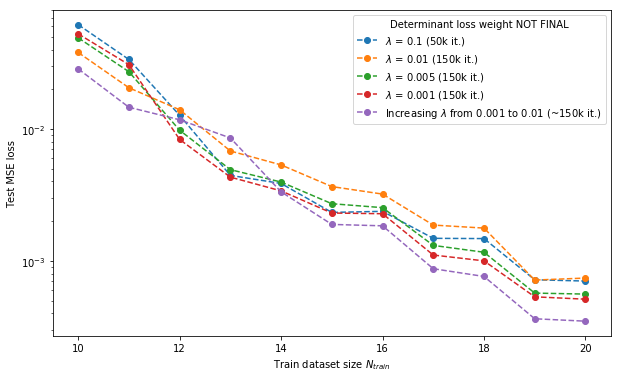

In [24]:
# Plot for dynamic det loss for - matrix entry model
dim = 2
train_range = list(range(10, 21, 1))
keys = [3, 2, 1, 0, 4]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}
def get_path(key, n_train, train_seed):
    checkpoint_dir = 'checkpoints/'
    if key <= 2:
        checkpoint_dir += 'round2_aug_lag_det_fixed_nolin/'
        checkpoint_dir += 'config_'+str(key)+'/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    elif key == 3:
        checkpoint_dir += 'round2_detweight3/'
        checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0.1, n_train, train_seed)
    elif key == 4:
        checkpoint_dir += 'round2_aug_lag_det/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    return checkpoint_dir + 'final.pkl'
labels = ["$\lambda$ = "+str(1e-3)+" (150k it.)", "$\lambda$ = "+str(5*1e-3)+" (150k it.)", "$\lambda$ = "+str(1e-2)+" (150k it.)", "$\lambda$ = "+str(1e-1)+" (50k it.)", "Increasing $\lambda$ from 0.001 to 0.01 (~150k it.)"]
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, model_class=lambda key:Net, label=lambda key: labels[key], legendTitle="Determinant loss weight NOT FINAL", filename="pnly_dyn")

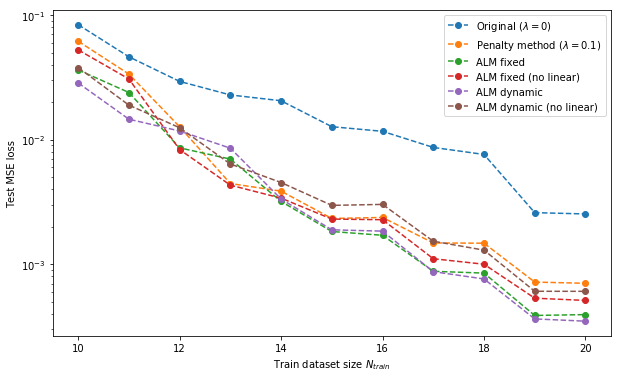

In [57]:
# ALM
def get_path(key, n_train, stat_val):
    if key == "ALM dynamic":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM dynamic (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_nolin/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed_nolin/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "Penalty method ($\lambda = 0.1$)":
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0.1, n_train, stat_val)
    else:
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

dim = 2
train_range = range(10, 21, 1)
keys = ["Original ($\lambda = 0$)", "Penalty method ($\lambda = 0.1$)", "ALM fixed", "ALM fixed (no linear)", "ALM dynamic", "ALM dynamic (no linear)"]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
config = {'weights': [1e-2] * 30, 'iterations': [5000] * 30}
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}

plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="aug_lag")


0.020507738
0.005218041
0.0030977502
#d62728
0.03254666


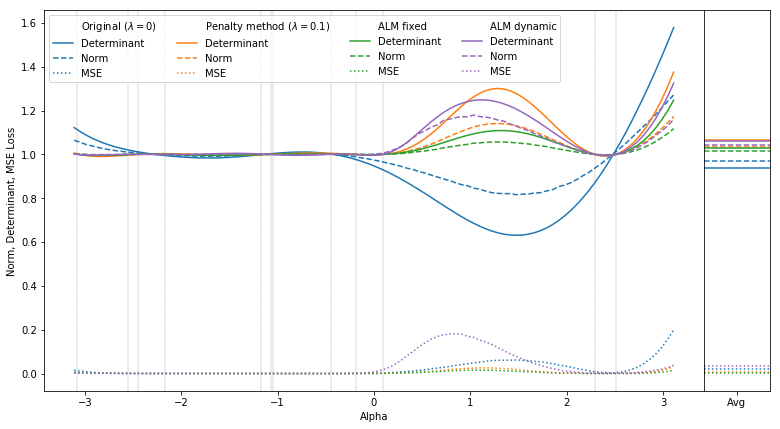

In [156]:
# Special analysis after det weight (Note: Make smoother with more test data in plot_det_analysis)
# TODO: Check that colors match colors on plot above + MAKE SMOOTHER
dim = 2
n_train = 12
train_seed = 1683
keys = ["Original ($\lambda = 0$)", "Penalty method ($\lambda = 0.1$)", "ALM fixed", "empty", "ALM dynamic"]
paths = []
labels = []
for key in keys:
    path = get_path(key, n_train, train_seed)
    paths.append(path)
    labels.append(key)
plot_det_analysis(dim, n_train, train_seed, labels, paths, npoints=64*4096, filename="alm_det_analysis_abs", use_absolute=False)

# TODO: Check that colors match colors on plot above + MAKE SMOOTHER

['']


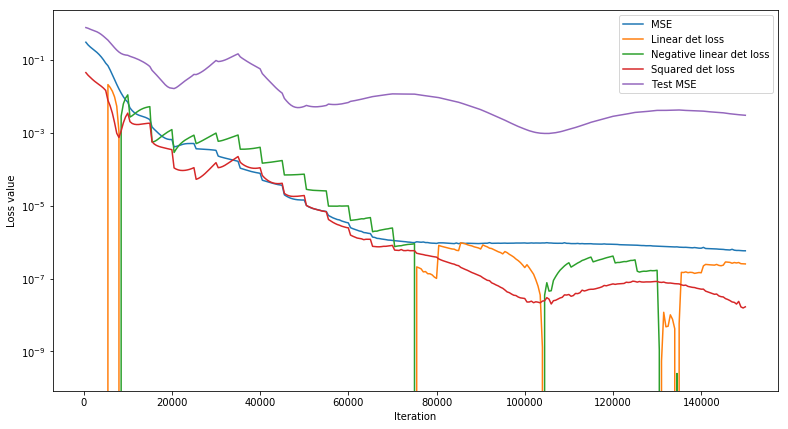

In [47]:
# Example of ALM during training
dim = 2
n_train = 12
stat_val = 1683
checkpoint_dir = 'checkpoints/'
checkpoint_dir += 'round2_aug_lag_det_fixed/'
checkpoint_dir += 'config_0/'
checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
paths = [checkpoint_dir + "final.pkl"]
# paths = [get_path("ALM dynamic", n_train, stat_val)]
plot_train_loss(dim, paths, includeTest=True)

# Appendix plots

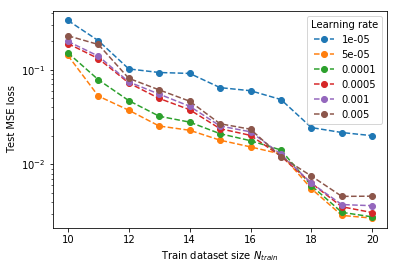

In [9]:
# Learning rate
dim = 2
train_range = range(10, 21, 1)
keys = [1e-5, 5*1e-5, 1e-4, 5*1e-4, 1e-3, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, max_iteration=50000, legendTitle="Learning rate", filename="lr_dim2_m3", small=True)

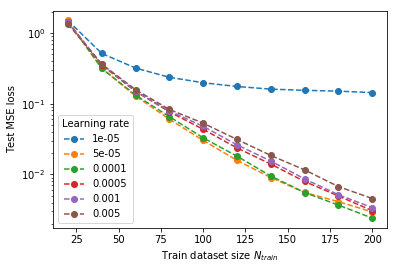

In [10]:
# Learning rate dim3
dim = 3
train_range = range(20, 201, 20)
keys = [1e-5, 5*1e-5, 1e-4, 5*1e-4, 1e-3, 5*1e-3]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_lr_statistical/'
    checkpoint_dir += 'dim-{}_lr-{}_ntrain-{}_lossfn-{}_seed-{}/'.format(dim, key, n_train, 'error', stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, max_iteration=50000, legendTitle="Learning rate", filename="lr_dim3_m3", small=True)

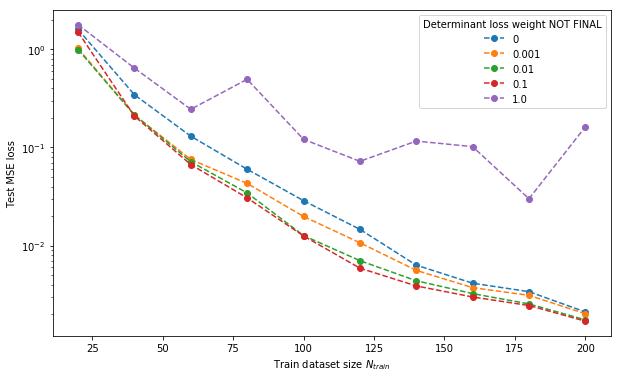

In [525]:
# Det loss weight for 3 dim
# TODO: weights [0, 1e-3, 1e-2, 1e-1, 1e0]
dim = 3
train_range = range(20, 201, 20)
keys = [0, 1e-3, 1e-2, 1e-1, 1e0]#[0, 1e-2, 0.1, 0.5, 1]
n_runs = 3
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Determinant loss weight NOT FINAL", filename="pnlty_det_dim3")

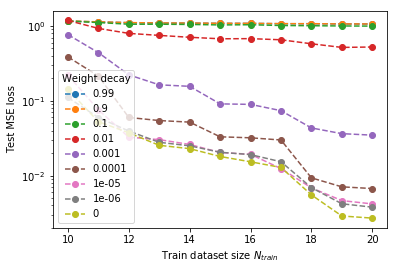

In [528]:
# Regularization weight
dim = 2
train_range = range(10, 21, 1)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Weight decay", filename="reg_weights", small=True)

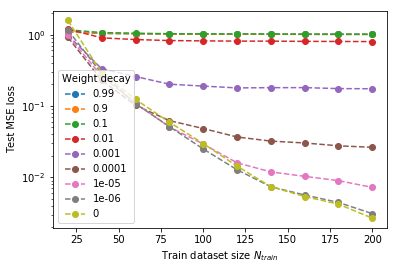

In [529]:
# Regularization weight for 3 dims
dim = 3
train_range = range(20, 201, 20)
keys = [0.99, 0.9, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]
n_runs = 9
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_weight_decay2/'
    checkpoint_dir += 'dim-{}_ntrain-{}_weightdecay-{}_seed-{}/'.format(dim, n_train, key, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Weight decay", filename="reg_weights_dim3", small=True)

In [139]:
# ALM
def get_path(key, n_train, stat_val):
    if key == "ALM dynamic":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM dynamic (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_nolin/'
        checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
            config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
            config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "ALM fixed (no linear)":
        checkpoint_dir = 'checkpoints/'
        checkpoint_dir += 'round2_aug_lag_det_fixed_nolin/'
        checkpoint_dir += 'config_0/'
        checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, stat_val)
    elif key == "Penalty method ($\lambda = 0.1$)":
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0.1, n_train, stat_val)
    else:
        checkpoint_dir = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(2, 0, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

dim = 2
train_range = range(10, 21, 1)
keys = ["Original ($\lambda = 0$)", "Penalty method ($\lambda = 0.1$)", "ALM fixed", "ALM fixed (no linear)", "ALM dynamic"]
n_runs = 10
stat_range = range(1683, 1683 + n_runs, 1)
config = {'weights': [1e-2] * 30, 'iterations': [5000] * 30}
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = "{}%".format(n)
    return percentile_

df = stats(dim, train_range, keys, stat_range, get_path)
df.groupby('key').agg({
        key: ['mean', 'std', percentile(25), percentile(50), percentile(75)] for key in train_range if key == 10 or key == 15 or key == 20
    }
)#.to_latex()
# df.describe()

10                                \
                                      mean       std       25%       50%   
key                                                                        
ALM dynamic                       0.028551  0.026700  0.009325  0.017179   
ALM fixed                         0.036335  0.041466  0.007078  0.014448   
ALM fixed (no linear)             0.052645  0.075604  0.007111  0.017469   
Original ($\lambda = 0$)          0.083873  0.084808  0.025126  0.051635   
Penalty method ($\lambda = 0.1$)  0.061773  0.089446  0.006697  0.018631   

                                                  15                      \
                                       75%      mean       std       25%   
key                                                                        
ALM dynamic                       0.041241  0.001889  0.001693  0.000804   
ALM fixed                         0.054447  0.001832  0.001621  0.000656   
ALM fixed (no linear)             0.073084  0.002305  0.001840  0.001263   
Original ($\lambda = 0$)          0.102614  0.012718  0.009706  0.006690   
Penalty method ($\lambda = 0.1$)  0.095302  0.002330  0.001577  0.001137   

                                                            20            \
                                       50%       75%      mean       std   
key                                                                        
ALM dynamic                       0.001271  0.002364  0.000349  0.000332   
ALM fixed                         0.001172  0.002869  0.000394  0.000422   
ALM fixed (no linear)             0.001476  0.003792  0.000512  0.000480   
Original ($\lambda = 0$)          0.010347  0.014473  0.002534  0.002381   
Penalty method ($\lambda = 0.1$)  0.002370  0.003468  0.000703  0.000487   

                                                                
                                       25%       50%       75%  
key                                                             
ALM dynamic                       0.000072  0.000211  0.000564  
ALM fixed                         0.000140  0.000174  0.000511  
ALM fixed (no linear)             0.000166  0.000375  0.000707  
Original ($\lambda = 0$)          0.000931  0.001674  0.003141  
Penalty method ($\lambda = 0.1$)  0.000260  0.000686  0.000999

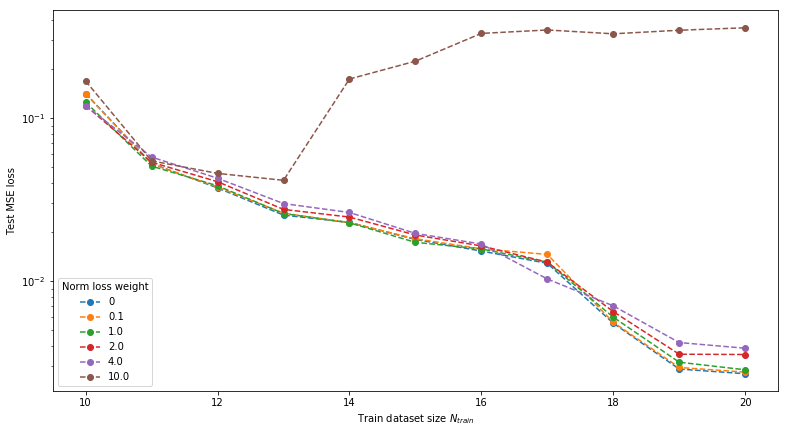

In [303]:
# Norm loss weight for 2 dims
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight3/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
dim = 2
train_range = range(10, 21, 1)
keys = [0, 1e-1, 1e0, 2e0, 4e0, 1e1] #[0, 1e-1, 1e0, 2e0, 4e0, 1e1, 2e1, 4e1, 1e2]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Norm loss weight")

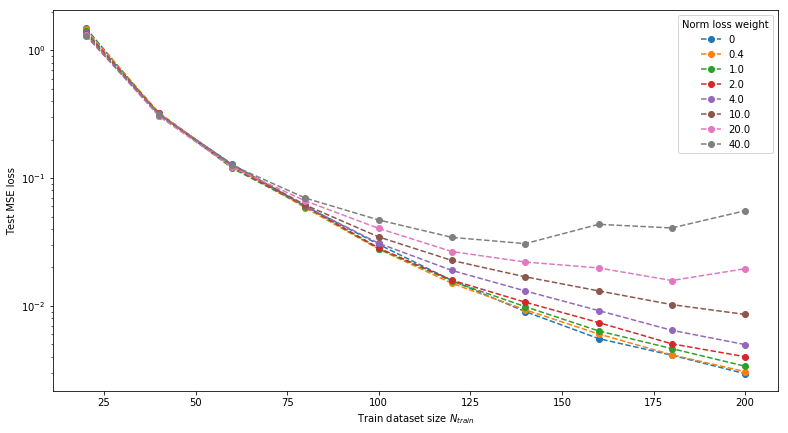

In [288]:
# Norm loss weight for 3 dims
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normweight3/'
    checkpoint_dir += 'dim-{}_normweight-{}_ntrain-{}_seed-{}/'.format(dim, key, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
dim = 3
train_range = range(20, 201, 20)
keys = [0, 4e-1, 1e0, 2e0, 4e0, 1e1, 2e1, 4e1]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, legendTitle="Norm loss weight")

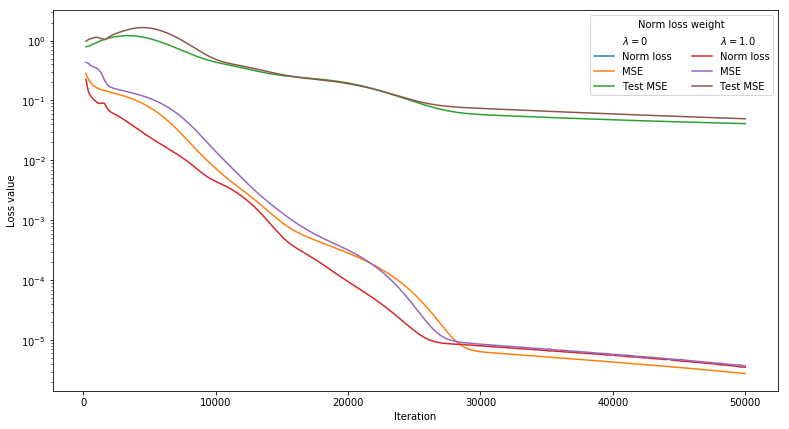

In [244]:
# TODO: DO not include
# Norm loss training
# change to 1e-1 weight
dim = 2
n_train = 12
train_seed = 1684
norm_weight = 1e0
paths = [get_path(0, n_train, train_seed), get_path(norm_weight, n_train, train_seed)]
plot_train_loss(dim, paths, labels=['$\lambda = $0', "$\lambda = $" + str(norm_weight)], includeTest=True, legendTitle="Norm loss weight")

['Original', 'Normed determinant']


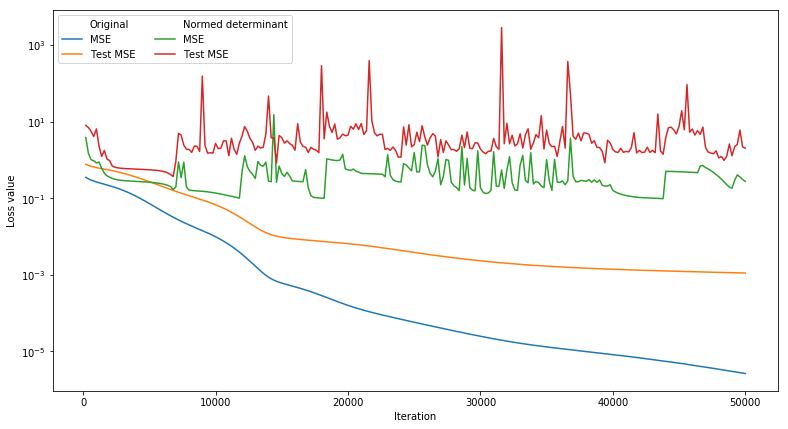

In [291]:
# Normed determinant
dim = 2
train_seed = 1683
n_train = 20
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
paths = [get_path("orig", n_train, train_seed), get_path("normed", n_train, train_seed)]
plot_train_loss(dim, paths, labels=["Original", "Normed determinant"], includeTest=True)

['Original', 'Normed determinant']


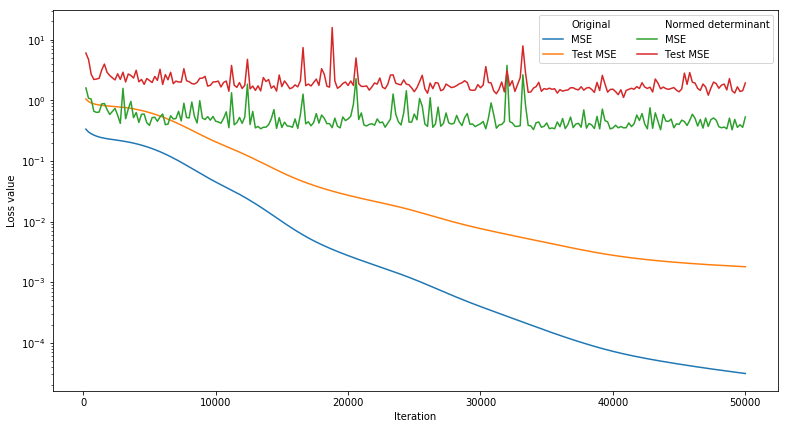

In [290]:
# Normed determinant
dim = 3
train_seed = 1683
n_train = 200
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_det/'
    checkpoint_dir += 'dim-{}_normeddet-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
paths = [get_path("orig", n_train, train_seed), get_path("normed", n_train, train_seed)]
plot_train_loss(dim, paths, labels=["Original", "Normed determinant"], includeTest=True)

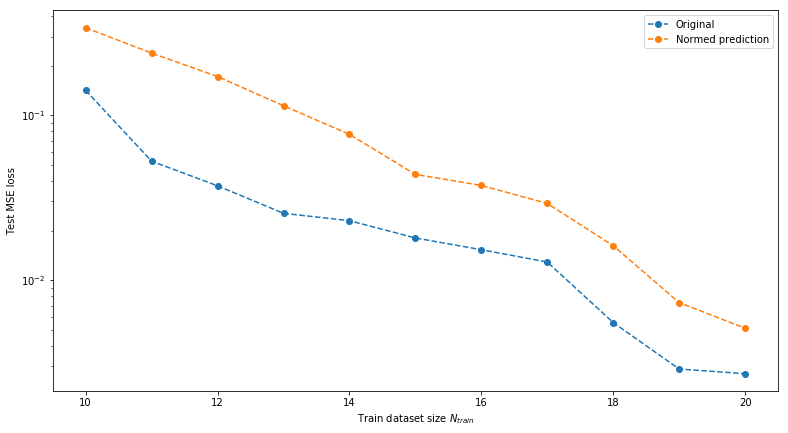

In [221]:
# Normed prediction
dim = 2
train_range = range(10, 21, 1)
keys = ["Original", "Normed prediction"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_pred")

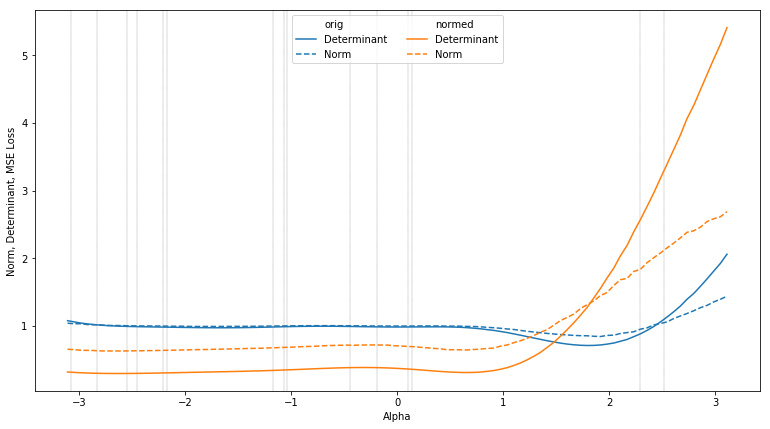

In [231]:
# Normed prediction explanation
dim = 2
n_train = 15
train_seed = 1683
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format(key, dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'

paths = []
labels = []
for key in ["orig", "normed"]:
    path = get_path(key, n_train, train_seed)
    paths.append(path)
    labels.append(str(key))
plot_det_analysis(dim, n_train, train_seed, labels, paths, use_absolute=False, include_mse=False, scale_by_mean=True)


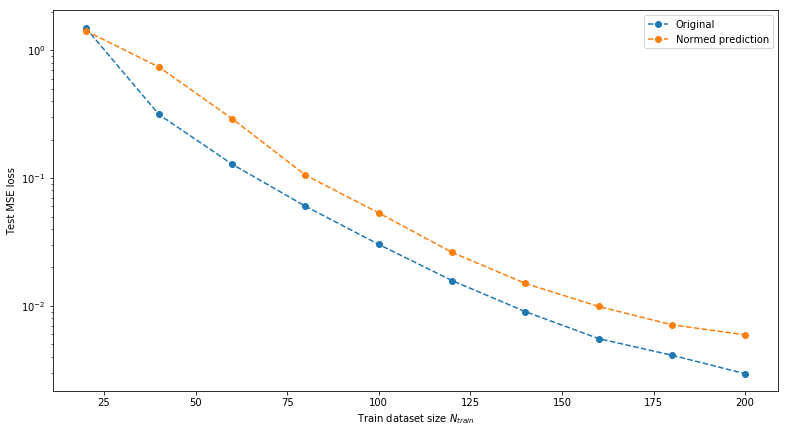

In [292]:
# Normed prediction dim3
dim = 3
train_range = range(20, 201, 20)
keys = ["Original", "Normed prediction"]
n_runs = 20
stat_range = range(1683, 1683 + n_runs, 1)
def get_path(key, n_train, stat_val):
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_normed_pred/'
    checkpoint_dir += 'dim-{}_normedpred-{}_ntrain-{}_seed-{}/'.format("orig" if key == "Original" else "normed", dim, n_train, stat_val)
    return checkpoint_dir + 'final.pkl'
plot_test_loss_statistical(dim, train_range, keys, stat_range, get_path, filename="normed_pred")

['1683', '1684', '1685', '1686', '1687', '1688', '1689', '1690', '1691', '1692']


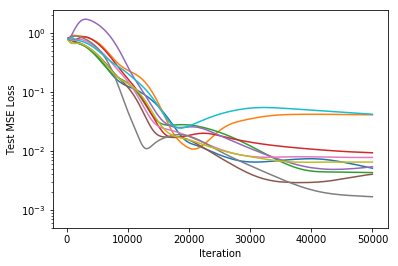

In [178]:
# ALM variance visualization
paths = []
labels = []
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
n_train = 12
for train_seed in range(1683,1683+10,1):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_detweight3/'
    checkpoint_dir += 'dim-{}_detweight-{}_ntrain-{}_seed-{}/'.format(dim, 0.1, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(train_seed))

plot_train_loss(dim, paths, labels=labels, includeTest=True, legendTitle="Random seed", only_test=True, ylabel="Test MSE Loss", filename="rand_test_pnlty", small=True, legend=False, miny=5*1e-4)

['1683', '1684', '1685', '1686', '1687', '1688', '1689', '1690', '1691', '1692']


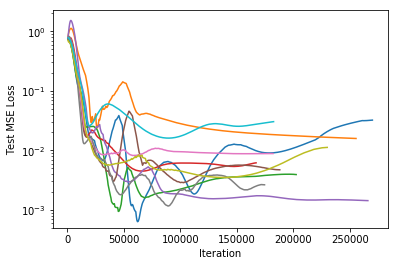

In [177]:
# ALM variance visualization
paths = []
labels = []
config = {'constraint_sq_weight': 0.001,
          'constraint_sq_weight_multiplier': 1.05,
          'eps': 1e-3,
          'gam': 0.1,
          'eps_gam_decay_rate': 0.95,
          'grad_threshold': None,
          'iterations': 50}
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
n_train = 12
for train_seed in range(1683,1683+10,1):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_det/'
    checkpoint_dir += 'sqweight-{}_sqwmul-{}_eps-{}_gam-{}_decrate-{}_gradthresh-{}_it-{}/'.format(
        config['constraint_sq_weight'], config['constraint_sq_weight_multiplier'], config['eps'], config['gam'],
        config['eps_gam_decay_rate'], config['grad_threshold'], config['iterations'])
    checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(train_seed))

plot_train_loss(dim, paths, labels=labels, includeTest=True, legendTitle="Random seed", only_test=True, ylabel="Test MSE Loss", filename="rand_test_alm_dyn", small=True, legend=False, miny=5*1e-4)

['1683', '1684', '1685', '1686', '1687', '1688', '1689', '1690', '1691', '1692']


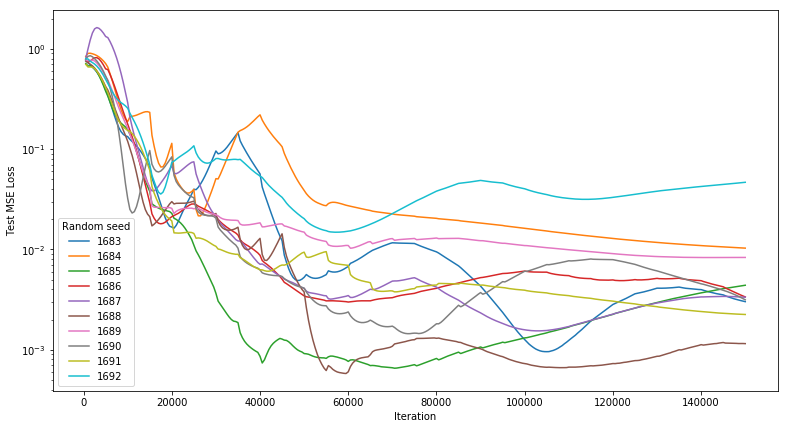

In [166]:
# ALM variance visualization
dim = 2
paths = []
labels = []
config = {'weights': [1e-2] * 30, 'iterations': [5000] * 30}
train_seed = 1683
norm_path = 'checkpoints/round2_detweight3/dim-{}_detweight-{}_ntrain-{}_seed-{}/final.pkl'.format(2, 0.1, n_train, train_seed)
n_train = 12
for train_seed in range(1683,1683+10,1):#[6]:#
    checkpoint_dir = 'checkpoints/'
    checkpoint_dir += 'round2_aug_lag_det_fixed/'
    checkpoint_dir += 'config_0/'
    checkpoint_dir += 'dim-{}_ntrain-{}_seed-{}/'.format(dim, n_train, train_seed)
    paths.append(checkpoint_dir + 'final.pkl')
    labels.append(str(train_seed))

plot_train_loss(dim, paths, labels=labels, includeTest=True, legendTitle="Random seed", only_test=True, ylabel="Test MSE Loss", filename="rand_test_alm_fixed")

In [ ]:
# TODO: ALM dynamic for 3 dim

In [ ]:
# TODO: ALM fixed for 3 dim